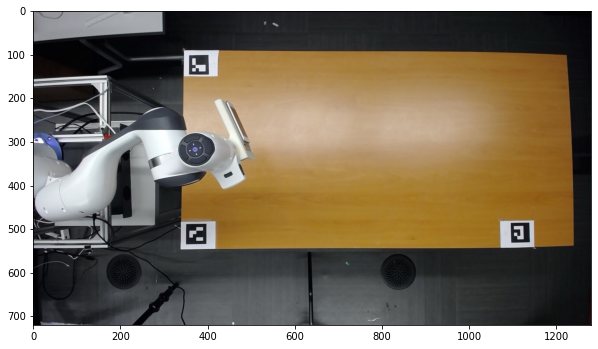

In [61]:
# Find tag positions in camera space
import cv2
import matplotlib.pyplot as plt

        
# Hide grid lines
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)

img_path = 'calib_data/camera_shot.jpg'
    
im = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [62]:
import numpy as np;
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

intrinsic_path = 'calib_data/c930-720p-calib.yaml'
with open(intrinsic_path) as fr:
    c = load(fr, Loader=Loader)
    cam_mat = np.array(c['camera_matrix'])
    distortion = np.array(c['dist_coefs'])

In [63]:
import cv2.aruco as aruco
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
aruco_param = aruco.DetectorParameters_create()

In [64]:
def __FindArucoMarkers(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters = aruco_param)
    #print(f"Marker ids are {ids}")
    ids = [ii[0] for ii in ids] if ids is not None else []
    # rv, tv, _o = aruco.estimatePoseSingleMarkers(corners, markerSide / 1000, camMat, dist)
    # rm = [cv2.Rodrigues(rvec)[0] for rvec in rv] # convert to rotation matrix
    # res = zip(ids, rm, tv) # (tagid, rotation_mat, translation_vec)
    #print(list(res))
    #print(ids)
    return corners, ids

In [65]:
def __FindMarkerPoses(corners, ids, ids_to_find, camMat, distParams, markerSize):
    selected_ids = [a for a in ids if a in ids_to_find]
    selected = [corners[i] for i in range(0, len(corners)) if ids[i] in ids_to_find]
    if len(selected_ids) > 0:
        rv, tv, _o = aruco.estimatePoseSingleMarkers(selected, markerSize / 1000, camMat, distParams)
        rm = [cv2.Rodrigues(rvec)[0] for rvec in rv] # convert to rotation matrix
        res = zip(selected_ids, rm, tv) # (tagid, rotation_mat, translation_vec)
        #print(list(res))
        #print(ids)
        return res
    else:
        return iter(())

In [66]:
marker_corners, marker_ids = __FindArucoMarkers(im)

In [67]:
tags_to_find = [1, 2, 3]
tag_size = 80 # in mm
irt = __FindMarkerPoses(marker_corners, marker_ids, tags_to_find, cam_mat, distortion, tag_size) 

In [68]:
results = {}
for tag_id, tag_rot, tag_trans in irt:
    results[tag_id] = tag_trans.flatten().tolist()
camera_corners = results

In [69]:
# Flip x-axis to make the Kinect coordinates righ-handed
kinect_corners = {1: [-0.2846465, 0.7482843, 0.2392055], 3: [-0.2392994, 0.7137539, 1.589764], 2: [-0.9974216, 0.6606016, 1.61386], 4: [-1.042769, 0.695132, 0.2633016]}
# Offset Kinect corners by their margin
kinect_corner_one = np.array(kinect_corners[1])
kinect_corner_two = np.array(kinect_corners[2])
kinect_corner_three = np.array(kinect_corners[3])
kinect_corner_four = np.array(kinect_corners[4])
# center = (kinect_corner_one + kinect_corner_two) / 2
offset = (0.04 + 0.02) * 1.41414
dir_one_three = kinect_corner_three - kinect_corner_one
dir_one_three = dir_one_three / np.linalg.norm(dir_one_three)
dir_three_two = kinect_corner_two - kinect_corner_three
dir_three_two = dir_three_two / np.linalg.norm(dir_three_two)
dir_two_four = kinect_corner_four - kinect_corner_two
dir_two_four = dir_two_four / np.linalg.norm(dir_two_four)
dir_four_one = kinect_corner_one - kinect_corner_four
dir_four_one = dir_four_one / np.linalg.norm(dir_four_one)

dir_corner_one = (dir_one_three - dir_four_one) / 2
dir_corner_one = dir_corner_one / np.linalg.norm(dir_corner_one)

dir_corner_two = (dir_two_four - dir_three_two) / 2
dir_corner_two = dir_corner_two / np.linalg.norm(dir_corner_two)

dir_corner_three = (dir_three_two - dir_one_three) / 2
dir_corner_three = dir_corner_three / np.linalg.norm(dir_corner_three)

# center_to_kc_one = center_to_kc_one / np.linalg.norm(center_to_kc_one)
kinect_corner_one_offset = kinect_corner_one + dir_corner_one * offset
kinect_corner_two_offset = kinect_corner_two + dir_corner_two * offset
#center_to_kc_three = kinect_corner_three - center
#center_to_kc_three = center_to_kc_three / np.linalg.norm(center_to_kc_three)
kinect_corner_three_offset = kinect_corner_three + dir_corner_three * offset
kinect_points = np.transpose(np.array([kinect_corner_one_offset, kinect_corner_two_offset, kinect_corner_three_offset]))
kinect_points

array([[-0.34245371, -0.93961439, -0.30113199],
       [ 0.74255769,  0.66632821,  0.7110925 ],
       [ 0.30105033,  1.55201516,  1.53172179]])

In [70]:
camera_points = np.transpose(np.array([camera_corners[1], camera_corners[2], camera_corners[3]]))
camera_points

array([[ 0.88707852, -0.45699373, -0.45973243],
       [ 0.27640449, -0.4243489 ,  0.27562808],
       [ 1.42094433,  1.41769892,  1.38979982]])

In [71]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [72]:
rigid_transform_3D(kinect_points, camera_points)


(array([[-0.03574307,  0.04855419, -0.99818081],
        [ 0.99895304,  0.03027306, -0.03429816],
        [ 0.02855267, -0.99836167, -0.04958541]]),
 array([[1.06315327],
        [0.58704665],
        [2.1859963 ]]))